In [17]:
# ================================
# Q1 — Polynomial Regression (degrees 1..6) with optional L1/L2
# ================================
# Paste into a Jupyter cell. Make sure X (2D array or DataFrame) and y (1D array/Series)
# are available in the notebook namespace, or use the example at the bottom to test.
#
# Outputs:
#  - For each reg_type ('none','l1','l2'): a plot Degree vs MSE (train+val)
#  - For l1 and l2: plot Alpha vs validation MSE (log scale)
#  - Printed best degree per reg type, best alpha for l1/l2, and non-zero coeffs for best l1 model.
#
# Notes:
#  - Uses sklearn's LinearRegression, Lasso, Ridge
#  - Scales polynomial features (StandardScaler) before fitting regularized models
#  - Uses a single random train/validation split (configurable)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# ====== Configuration ======
username = "Sharvari1234"   # will appear on plots
random_state = 42           # reproducible splits
degrees = list(range(1, 7)) # 1..6
default_alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]  # candidate reg strengths
test_size = 0.2             # fraction for validation (we treat as val set)
verbose = True

# ====== Main function ======
def run_poly_regression(X, y,
                        degrees=degrees,
                        reg_types=('none', 'l1', 'l2'),
                        alphas=default_alphas,
                        val_size=test_size,
                        random_state=random_state,
                        username=username,
                        show_plots=True):
    """
    Run polynomial regression across degrees and regularizers.

    Parameters
    ----------
    X : ndarray or DataFrame, shape (n_samples, n_features)
        Input features (raw).
    y : ndarray or Series, shape (n_samples,)
        Target values.
    degrees : iterable of int
        Polynomial degrees to try (1..6 by default).
    reg_types : tuple
        ('none', 'l1', 'l2') - which regularization types to evaluate.
    alphas : list of float
        Candidate alpha values (regularization strengths) for L1/L2.
    val_size : float
        Fraction of data to use for validation.
    random_state : int
        Seed for reproducible splits.
    username : str
        Text to display on plots.
    show_plots : bool
        Whether to show matplotlib plots.

    Returns
    -------
    results : dict
        results[reg_type] -> DataFrame with columns: degree, train_mse, val_mse, chosen_alpha (NaN for none)
    extras : dict
        extra info (best settings, coefficients)
    """
    # Ensure numpy arrays
    X_np = np.array(X)
    y_np = np.array(y).ravel()

    # Train/validation split
    X_train_full, X_val_full, y_train, y_val = train_test_split(
        X_np, y_np, test_size=val_size, random_state=random_state)

    results = {}
    extras = {}

    for reg in reg_types:
        degree_records = []
        # For alpha-vs-val-MSE plot (aggregate across degrees) we'll keep a table:
        alpha_valmse = {alpha: [] for alpha in alphas} if reg in ('l1','l2') else None

        for d in degrees:
            # Build polynomial features
            poly = PolynomialFeatures(degree=d, include_bias=False)
            Xtr_poly = poly.fit_transform(X_train_full)
            Xv_poly = poly.transform(X_val_full)

            # Standardize features for stability (important for L1/L2)
            scaler = StandardScaler()
            Xtr_scaled = scaler.fit_transform(Xtr_poly)
            Xv_scaled = scaler.transform(Xv_poly)

            if reg == 'none':
                # Ordinary least squares on scaled polynomial features
                model = LinearRegression()
                model.fit(Xtr_scaled, y_train)
                ytr_pred = model.predict(Xtr_scaled)
                yv_pred = model.predict(Xv_scaled)
                train_mse = mean_squared_error(y_train, ytr_pred)
                val_mse = mean_squared_error(y_val, yv_pred)
                chosen_alpha = np.nan

            else:
                # For L1 and L2: search over alphas and choose alpha that minimizes validation MSE for this degree
                best_alpha = None
                best_val_mse = np.inf
                best_train_mse = np.inf
                best_model = None

                for alpha in alphas:
                    if reg == 'l1':
                        mdl = Lasso(alpha=alpha, max_iter=10000, random_state=random_state)
                    else:
                        mdl = Ridge(alpha=alpha, random_state=random_state)

                    mdl.fit(Xtr_scaled, y_train)
                    ytr = mdl.predict(Xtr_scaled)
                    yv = mdl.predict(Xv_scaled)
                    tr_mse = mean_squared_error(y_train, ytr)
                    v_mse = mean_squared_error(y_val, yv)

                    # record for alpha plot
                    alpha_valmse[alpha].append(v_mse)

                    if v_mse < best_val_mse:
                        best_val_mse = v_mse
                        best_train_mse = tr_mse
                        best_alpha = alpha
                        best_model = mdl

                # Use best model for this degree
                train_mse = best_train_mse
                val_mse = best_val_mse
                chosen_alpha = best_alpha
                # store last best_model for potential coefficient inspection later
                last_best_model = best_model

            degree_records.append({
                'degree': d,
                'train_mse': train_mse,
                'val_mse': val_mse,
                'chosen_alpha': chosen_alpha
            })

        # Create DataFrame of results for this reg type
        df_res = pd.DataFrame(degree_records)
        results[reg] = df_res

        # For extras: pick best degree (lowest val_mse) and store model info
        best_row = df_res.loc[df_res['val_mse'].idxmin()]
        best_degree = int(best_row['degree'])
        extras[reg] = {'best_degree': best_degree, 'best_val_mse': best_row['val_mse'],
                       'best_train_mse': best_row['train_mse'],
                       'chosen_alpha_for_best_degree': best_row['chosen_alpha']}

        # If reg is l1, get coefficients of best model for best_degree to identify important features
        if reg == 'l1':
            # Refit polynomial/scaler/model to retrieve coefficients for best degree and chosen alpha
            d = best_degree
            poly = PolynomialFeatures(degree=d, include_bias=False)
            Xtr_poly = poly.fit_transform(X_train_full)
            Xv_poly = poly.transform(X_val_full)
            scaler = StandardScaler()
            Xtr_scaled = scaler.fit_transform(Xtr_poly)
            chosen_alpha = int(best_row['chosen_alpha']) if not np.isnan(best_row['chosen_alpha']) else best_row['chosen_alpha']

            # need to pick the chosen alpha stored (it could be float like 0.1)
            chosen_alpha = best_row['chosen_alpha']
            # Refit chosen model
            if chosen_alpha is not None and (not pd.isna(chosen_alpha)):
                mdl = Lasso(alpha=chosen_alpha, max_iter=10000, random_state=random_state)
                mdl.fit(Xtr_scaled, y_train)
                coefs = mdl.coef_
                feature_names = poly.get_feature_names_out()  # sklearn>=1.0
                # scale back? coefficients correspond to scaled features, but relative importance is fine
                nonzero_idx = np.where(np.abs(coefs) > 1e-8)[0]
                important = [(feature_names[i], coefs[i]) for i in nonzero_idx]
                # sort by absolute weight descending
                important_sorted = sorted(important, key=lambda x: abs(x[1]), reverse=True)
                extras[reg]['l1_nonzero_coefs'] = important_sorted
                extras[reg]['l1_feature_names'] = feature_names
            else:
                extras[reg]['l1_nonzero_coefs'] = []

        # For plotting alpha vs validation MSE (aggregate), average collected v_mse per alpha across degrees
        if reg in ('l1', 'l2'):
            avg_val_mse_per_alpha = {alpha: np.mean(alpha_valmse[alpha]) if len(alpha_valmse[alpha])>0 else np.nan
                                     for alpha in alphas}
            extras[reg]['alpha_valmse'] = avg_val_mse_per_alpha

    # ====== Plot Degree vs MSE for each reg type ======
    if show_plots:
        for reg in reg_types:
            df_r = results[reg]
            plt.figure(figsize=(8,5))
            plt.plot(df_r['degree'], df_r['train_mse'], marker='o', label='Train MSE')
            plt.plot(df_r['degree'], df_r['val_mse'], marker='o', label='Val MSE')
            plt.xlabel("Polynomial Degree")
            plt.ylabel("Mean Squared Error")
            plt.title(f"Degree vs MSE ({reg.upper()})")
            plt.xticks(degrees)
            plt.legend()
            plt.grid(True)
            plt.text(0.95, 0.95, username, ha='right', va='top', transform=plt.gca().transAxes, color='gray')
            plt.show()

        # For L1 and L2: plot alpha vs avg validation MSE (log x-axis)
        for reg in ('l1', 'l2'):
            if reg in extras and 'alpha_valmse' in extras[reg]:
                alph = list(extras[reg]['alpha_valmse'].keys())
                mvals = list(extras[reg]['alpha_valmse'].values())
                plt.figure(figsize=(7,4))
                plt.plot(alph, mvals, marker='o')
                plt.xscale('log')
                plt.xlabel("Alpha (log scale)")
                plt.ylabel("Average Validation MSE (avg over degrees)")
                plt.title(f"Alpha vs Avg Validation MSE ({reg.upper()})")
                plt.grid(True)
                plt.text(0.95, 0.95, username, ha='right', va='top', transform=plt.gca().transAxes, color='gray')
                plt.show()

    # ====== Print summary results ======
    if verbose:
        print("=== Summary of Results ===")
        for reg in reg_types:
            row = results[reg]
            best_idx = row['val_mse'].idxmin()
            best = row.loc[best_idx]
            print(f"\nRegularization: {reg.upper()}")
            print(f"  Best degree (by val MSE): {int(best['degree'])}")
            print(f"  Train MSE (best degree): {best['train_mse']:.6f}")
            print(f"  Val   MSE (best degree): {best['val_mse']:.6f}")
            if reg in ('l1', 'l2'):
                print(f"  Chosen alpha (for best degree): {best['chosen_alpha']}")
                # Also show alpha->avg valmse table if available
                avals = extras[reg].get('alpha_valmse', None)
                if avals:
                    print(f"  Average Val MSE per alpha (avg across degrees):")
                    for a, v in avals.items():
                        print(f"    alpha={a}: avg_val_mse={v:.6f}")

        # If L1 extras exist, print important non-zero coefficients for best L1 model
        if 'l1' in extras and 'l1_nonzero_coefs' in extras['l1']:
            print("\nL1 (best) non-zero coefficients (feature, coef) — ordered by |coef| desc:")
            for feat, coef in extras['l1']['l1_nonzero_coefs'][:30]: # print top 30
                print(f"  {feat:40s}  {coef: .6e}")

    return results, extras

# =========================
# Example usage (uncomment to test)
# =========================
# If you already have X,y in the notebook, just call:
# results, extras = run_poly_regression(X, y)
#
# If you want a quick synthetic test, uncomment below:
# ----------------------------------------------------------------
# # Synthetic test (uncomment to run a quick check)
# from sklearn.datasets import make_regression
# Xs, ys = make_regression(n_samples=1000, n_features=3, noise=10.0, random_state=0)
# results, extras = run_poly_regression(Xs, ys)
# ----------------------------------------------------------------

# Note:
# - If your feature matrix X is a pandas DataFrame, PolynomialFeatures.get_feature_names_out()
#   will produce nice feature names (sklearn>=1.0). If using older sklearn, feature names may differ.
# - For big d and many original features, polynomial feature space grows quickly (watch memory).


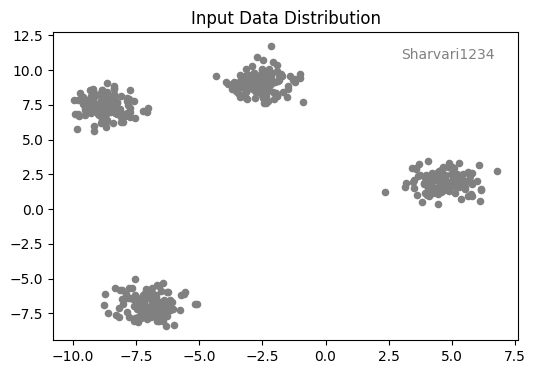

✅ Converged after 2 iterations
✅ Converged after 6 iterations
✅ Converged after 5 iterations
✅ Converged after 15 iterations
✅ Converged after 12 iterations
✅ Converged after 11 iterations
✅ Converged after 8 iterations
✅ Converged after 15 iterations


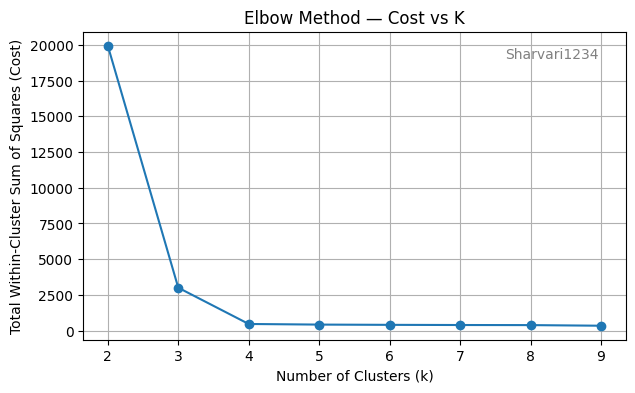

✅ Converged after 2 iterations
✅ Converged after 6 iterations
✅ Converged after 5 iterations
✅ Converged after 15 iterations
✅ Converged after 12 iterations
✅ Converged after 11 iterations
✅ Converged after 8 iterations
✅ Converged after 15 iterations


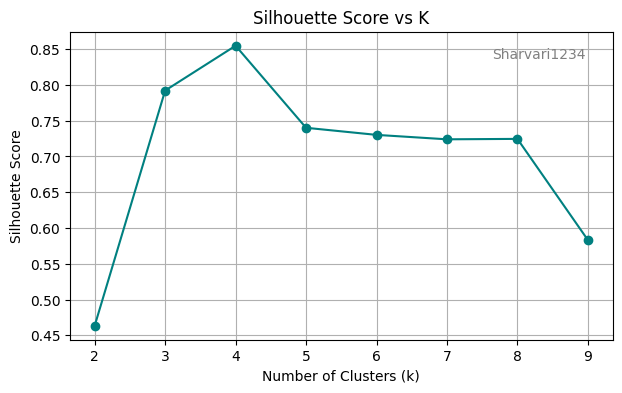

✅ Converged after 5 iterations


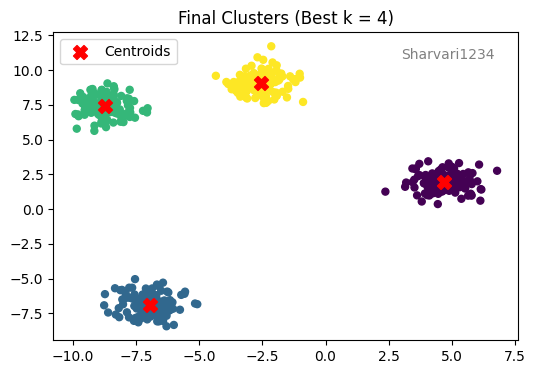

In [18]:
# ==========================================
# Q2 — Custom K-Means Clustering Implementation
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

username = "Sharvari1234"

# -------------------------------
# Step 1: Define Custom KMeans Class
# -------------------------------
class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None

    def fit(self, X):
        """Fit K-Means clustering on data X."""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Randomly initialize centroids
        random_idx = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_idx, :]

        for iteration in range(self.max_iter):
            # Step 1: Assign clusters (closest centroid)
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Step 2: Compute new centroids
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])

            # Step 3: Check for convergence
            shift = np.linalg.norm(new_centroids - self.centroids)
            if shift < self.tol:
                print(f"✅ Converged after {iteration+1} iterations")
                break

            self.centroids = new_centroids

        self.labels_ = labels
        return self

    def predict(self, X):
        """Assign cluster labels for given data."""
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def getCost(self, X):
        """Compute within-cluster sum of squares (WCSS / inertia)."""
        labels = self.predict(X)
        cost = 0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                cost += np.sum((cluster_points - self.centroids[k]) ** 2)
        return cost


# -------------------------------
# Step 2: Example Dataset (Synthetic)
# -------------------------------
X, y_true = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=0.7, random_state=42)

plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], s=20, c='gray')
plt.title("Input Data Distribution")
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
plt.show()

# -------------------------------
# Step 3: Elbow Method
# -------------------------------
k_values = range(2, 10)
costs = []

for k in k_values:
    model = CustomKMeans(n_clusters=k, max_iter=300, random_state=42)
    model.fit(X)
    cost = model.getCost(X)
    costs.append(cost)

plt.figure(figsize=(7, 4))
plt.plot(k_values, costs, marker='o')
plt.title("Elbow Method — Cost vs K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Total Within-Cluster Sum of Squares (Cost)")
plt.grid(True)
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
plt.show()

# -------------------------------
# Step 4: Silhouette Score Analysis
# -------------------------------
sil_scores = []
for k in k_values:
    model = CustomKMeans(n_clusters=k, max_iter=300, random_state=42)
    model.fit(X)
    labels = model.labels_
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(X, labels)
        sil_scores.append(sil)
    else:
        sil_scores.append(np.nan)

plt.figure(figsize=(7, 4))
plt.plot(k_values, sil_scores, marker='o', color='teal')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
plt.show()

# -------------------------------
# Step 5: Final Visualization for Best K
# -------------------------------
best_k = k_values[int(np.nanargmax(sil_scores))]
best_model = CustomKMeans(n_clusters=best_k, max_iter=300, random_state=42).fit(X)
labels = best_model.labels_

plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=25)
plt.scatter(best_model.centroids[:, 0], best_model.centroids[:, 1], c='red', s=100, marker='X', label='Centroids')
plt.title(f"Final Clusters (Best k = {best_k})")
plt.legend()
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
plt.show()


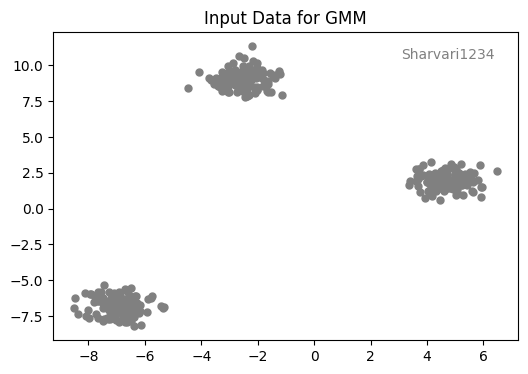

✅ GMM converged after 14 iterations
✅ GMM converged after 5 iterations


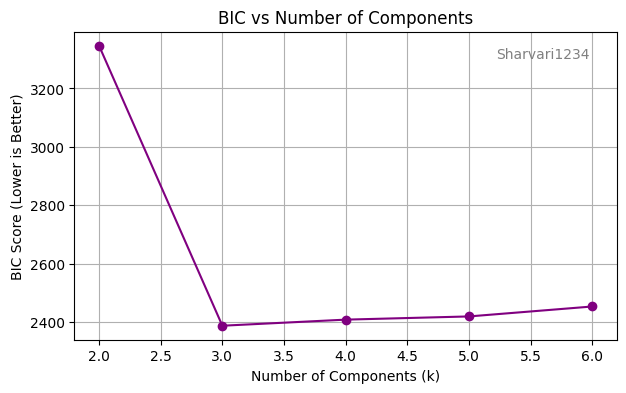

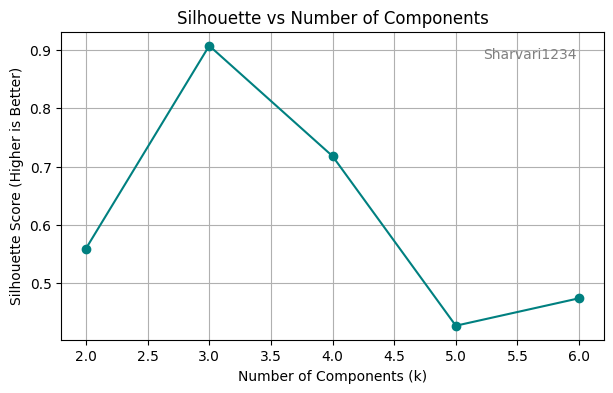

✅ GMM converged after 5 iterations


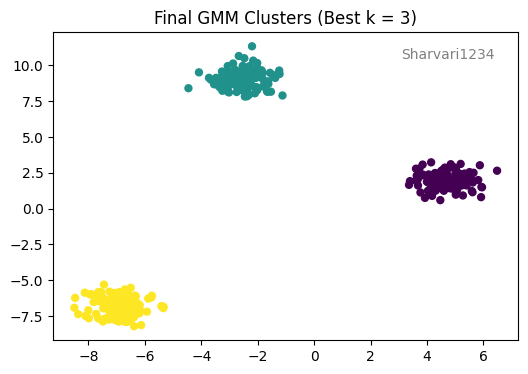

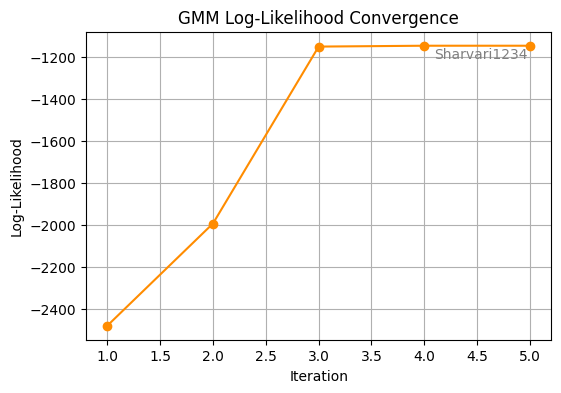

In [19]:
# ==========================================
# Q3 — Custom Gaussian Mixture Model (GMM)
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

username = "Sharvari1234"

# -------------------------------
# Step 1: Define Custom GMM Class
# -------------------------------
class CustomGMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.log_likelihoods_ = []

    def _initialize_parameters(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        random_idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[random_idx]
        self.covariances_ = np.array([np.cov(X, rowvar=False)] * self.n_components)
        self.weights_ = np.ones(self.n_components) / self.n_components

    def _multivariate_gaussian(self, X, mean, cov):
        """Compute probability density of multivariate normal distribution."""
        n = X.shape[1]
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
        norm_const = 1.0 / (np.power((2 * np.pi), n / 2) * np.sqrt(det))
        diff = X - mean
        exponent = np.einsum('ij,jk,ik->i', diff, inv, diff)
        return norm_const * np.exp(-0.5 * exponent)

    def fit(self, X):
        """Fit the GMM to dataset X using EM algorithm."""
        X = np.asarray(X)
        n_samples, n_features = X.shape
        self._initialize_parameters(X)

        for iteration in range(self.max_iter):
            # E-Step: Calculate responsibilities (posterior probabilities)
            resp = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                resp[:, k] = self.weights_[k] * self._multivariate_gaussian(X, self.means_[k], self.covariances_[k])
            resp_sum = resp.sum(axis=1, keepdims=True)
            resp /= resp_sum

            # M-Step: Update parameters
            Nk = resp.sum(axis=0)
            self.weights_ = Nk / n_samples
            self.means_ = np.dot(resp.T, X) / Nk[:, np.newaxis]
            self.covariances_ = np.array([
                np.dot((resp[:, k][:, np.newaxis] * (X - self.means_[k])).T, (X - self.means_[k])) / Nk[k]
                for k in range(self.n_components)
            ])

            # Compute log-likelihood
            likelihood = np.sum(np.log(resp_sum))
            self.log_likelihoods_.append(likelihood)

            # Check convergence
            if iteration > 0 and abs(self.log_likelihoods_[-1] - self.log_likelihoods_[-2]) < self.tol:
                print(f"✅ GMM converged after {iteration+1} iterations")
                break

        return self

    def predict(self, X):
        """Assign each sample to the most probable component."""
        probs = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            probs[:, k] = self.weights_[k] * self._multivariate_gaussian(X, self.means_[k], self.covariances_[k])
        return np.argmax(probs, axis=1)

    def getMembership(self, X):
        """Return membership probabilities (posterior) for each component."""
        probs = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            probs[:, k] = self.weights_[k] * self._multivariate_gaussian(X, self.means_[k], self.covariances_[k])
        return probs / probs.sum(axis=1, keepdims=True)

    def getLikelihood(self):
        """Return final log-likelihood value."""
        return self.log_likelihoods_[-1]

    def drawLikelihood(self):
        """Plot log-likelihood vs iteration."""
        plt.figure(figsize=(6,4))
        plt.plot(range(1, len(self.log_likelihoods_)+1), self.log_likelihoods_, marker='o', color='darkorange')
        plt.title("GMM Log-Likelihood Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid(True)
        plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
        plt.show()

# -------------------------------
# Step 2: Example Dataset (Synthetic)
# -------------------------------
X, y_true = make_blobs(n_samples=400, n_features=2, centers=3, cluster_std=0.6, random_state=42)

plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], s=25, c='gray')
plt.title("Input Data for GMM")
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
plt.show()

# -------------------------------
# Step 3: Evaluate Different Numbers of Components (k)
# -------------------------------
k_values = range(2, 7)
bic_scores = []
silhouette_scores = []
likelihoods = []

for k in k_values:
    model = CustomGMM(n_components=k, max_iter=100, random_state=42)
    model.fit(X)
    labels = model.predict(X)
    n_params = k * X.shape[1] * (X.shape[1] + 3) / 2  # mean, cov, weight parameters
    bic = -2 * model.getLikelihood() + n_params * np.log(len(X))
    bic_scores.append(bic)
    silhouette_scores.append(silhouette_score(X, labels))
    likelihoods.append(model.getLikelihood())

# -------------------------------
# Step 4: Plot BIC and Silhouette vs k
# -------------------------------
plt.figure(figsize=(7,4))
plt.plot(k_values, bic_scores, marker='o', label='BIC', color='purple')
plt.xlabel("Number of Components (k)")
plt.ylabel("BIC Score (Lower is Better)")
plt.title("BIC vs Number of Components")
plt.grid(True)
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
plt.show()

plt.figure(figsize=(7,4))
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette', color='teal')
plt.xlabel("Number of Components (k)")
plt.ylabel("Silhouette Score (Higher is Better)")
plt.title("Silhouette vs Number of Components")
plt.grid(True)
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
plt.show()

# -------------------------------
# Step 5: Final Visualization for Best k
# -------------------------------
best_k = k_values[int(np.argmax(silhouette_scores))]
best_model = CustomGMM(n_components=best_k, max_iter=100, random_state=42).fit(X)
labels = best_model.predict(X)

plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=25)
plt.title(f"Final GMM Clusters (Best k = {best_k})")
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes, ha='right', va='top', color='gray')
plt.show()

# Plot log-likelihood convergence for best model
best_model.drawLikelihood()


Processing satellite1.png -> seg_satellite1_k3.mp4 (k=3, max_iter=30, pixel_step=2)


AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

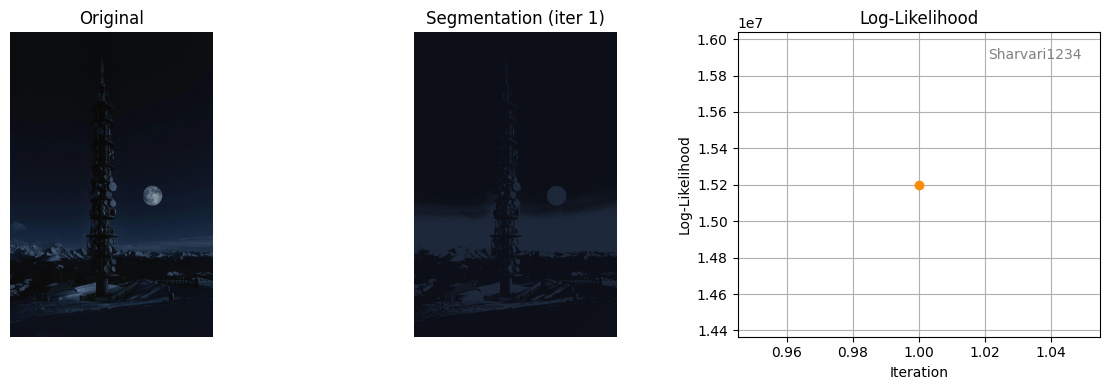

In [20]:
# ==========================================
# Q4 — Image Segmentation using custom GMM + segmentation video
# ==========================================
# Produces an mp4 for each input image showing:
#   [Original | Segmented (per iteration) | Log-likelihood vs iteration]
#
# Put your images in the notebook working directory (e.g. satellite1.png, satellite2.png)
# and edit image_files below if necessary.
#
# Requires: imageio, pillow, matplotlib, numpy
# If you don't have imageio-ffmpeg installed for MP4 encoding, install it:
#   pip install imageio imageio-ffmpeg pillow
#
# Usage: run this cell. It writes files like 'seg_satellite1_k3.mp4'.
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import os
from IPython.display import HTML, display

username = "Sharvari1234"   # will appear on plots

# -----------------------
# Utility: robust multivariate Gaussian pdf (vectorized)
# -----------------------
def mvn_pdf(X, mean, cov):
    # X: (n_samples, n_features)
    # mean: (n_features,)
    # cov: (n_features, n_features)
    d = X.shape[1]
    # regularize covariance for numerical stability
    reg = 1e-6 * np.eye(d)
    cov_reg = cov + reg
    try:
        inv = np.linalg.inv(cov_reg)
        det = np.linalg.det(cov_reg)
        if det <= 0:
            # fallback to diagonal with variances on diagonal
            diag = np.diag(np.diag(cov_reg))
            inv = np.linalg.inv(diag)
            det = np.prod(np.diag(diag))
    except np.linalg.LinAlgError:
        diag = np.diag(np.diag(cov_reg))
        inv = np.linalg.inv(diag)
        det = np.prod(np.diag(diag))
    diff = X - mean
    exponent = -0.5 * np.einsum('ij,jk,ik->i', diff, inv, diff)
    norm_const = 1.0 / (np.sqrt((2 * np.pi) ** d * max(det, 1e-12)))
    return norm_const * np.exp(exponent)

# -----------------------
# GMM EM implementation (returns history of parameters + log-likelihoods)
# -----------------------
def gmm_em(X, n_components=3, max_iter=50, tol=1e-4, random_state=None, diag_cov=False):
    """
    X: (n_samples, n_features)
    returns: dict with keys: 'weights', 'means', 'covs', 'log_likelihoods', 'responsibilities' (final)
    """
    rng = np.random.RandomState(random_state)
    n, d = X.shape

    # Initialize means randomly from samples
    idx = rng.choice(n, n_components, replace=False)
    means = X[idx].astype(float)

    # initialize covariances to data covariance
    data_cov = np.cov(X, rowvar=False) + 1e-6 * np.eye(d)
    covs = np.array([data_cov.copy() for _ in range(n_components)])
    weights = np.ones(n_components) / n_components

    log_likelihoods = []
    responsibilities = np.zeros((n, n_components))

    for it in range(max_iter):
        # E-step: compute responsibilities
        for k in range(n_components):
            cov_k = covs[k]
            if diag_cov:
                cov_k = np.diag(np.diag(cov_k))
            responsibilities[:, k] = weights[k] * mvn_pdf(X, means[k], cov_k)

        # normalize responsibilities
        row_sums = responsibilities.sum(axis=1, keepdims=True)
        # prevent zero division:
        row_sums[row_sums == 0] = 1e-12
        responsibilities = responsibilities / row_sums

        # compute log-likelihood
        ll = np.sum(np.log(row_sums))
        log_likelihoods.append(ll)

        # M-step: update parameters
        Nk = responsibilities.sum(axis=0)  # effective counts per component
        # Avoid zero Nk
        Nk[Nk == 0] = 1e-8

        weights = Nk / n
        means = (responsibilities.T @ X) / Nk[:, np.newaxis]

        for k in range(n_components):
            diff = X - means[k]
            # weighted covariance
            cov_k = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]
            # regularize
            covs[k] = cov_k + 1e-6 * np.eye(d)

        # check convergence (change in log-likelihood)
        if it > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            # converged
            break

    # final responsibilities
    for k in range(n_components):
        cov_k = covs[k]
        if diag_cov:
            cov_k = np.diag(np.diag(cov_k))
        responsibilities[:, k] = weights[k] * mvn_pdf(X, means[k], cov_k)
    responsibilities = responsibilities / (responsibilities.sum(axis=1, keepdims=True) + 1e-12)

    return {
        'weights': weights,
        'means': means,
        'covs': covs,
        'log_likelihoods': log_likelihoods,
        'responsibilities': responsibilities
    }

# -----------------------
# Function: create segmentation video for one image
# -----------------------
def segment_image_to_video(image_path,
                           out_mp4,
                           k=3,
                           max_iter=40,
                           pixel_step=2,
                           include_xy=True,
                           diag_cov=False,
                           make_fullsize_segment=True,
                           fps=6,
                           random_state=42):
    """
    image_path: path to input image (RGB)
    out_mp4: path to output mp4 file
    k: number of clusters (3 per assignment)
    max_iter: maximum EM iterations
    pixel_step: subsampling step for EM to speed up (1 = full)
    include_xy: include normalized (x,y) coordinates as features (helps spatial coherence)
    diag_cov: use diagonal covariance matrices (faster, more stable)
    make_fullsize_segment: if True, expand segmentation to original resolution
    fps: frames per second in video
    """
    print(f"Processing {image_path} -> {out_mp4} (k={k}, max_iter={max_iter}, pixel_step={pixel_step})")
    im = Image.open(image_path).convert('RGB')
    W, H = im.size
    arr = np.array(im).astype(np.float64) / 255.0  # normalize colors to [0,1]
    # Prepare pixel coordinate grid
    xs = np.arange(W)
    ys = np.arange(H)
    Xg, Yg = np.meshgrid(xs, ys)  # shape (H, W)

    # Prepare subsampled indices for EM to speed up (choose every pixel_step)
    coords = np.indices((H, W)).transpose(1, 2, 0).reshape(-1, 2)  # (H*W, 2) with (y,x)
    pixels = arr.reshape(-1, 3)  # (H*W, 3) (RGB)

    # select a subset of pixels for EM
    if pixel_step > 1:
        # keep pixels where both x%pixel_step==0 and y%pixel_step==0
        mask = (coords[:, 0] % pixel_step == 0) & (coords[:, 1] % pixel_step == 0)
        coords_sub = coords[mask]
        pixels_sub = pixels[mask]
        full_idx = np.where(mask)[0]
    else:
        coords_sub = coords
        pixels_sub = pixels
        full_idx = np.arange(len(pixels))

    # construct feature vector: [R,G,B,(x_norm,y_norm)]
    features = pixels_sub.copy()
    if include_xy:
        # normalize x in [0,1], y in [0,1]
        x_norm = coords_sub[:, 1] / (W - 1)
        y_norm = coords_sub[:, 0] / (H - 1)
        xy = np.stack([x_norm, y_norm], axis=1)
        features = np.hstack([features, xy])

    # Run GMM EM on features, but iterate and capture params per iteration
    rng = np.random.RandomState(random_state)

    # We'll implement EM with manual iterations to capture intermediate responsibilities and likelihoods
    n_samples, d = features.shape
    # Init:
    idx = rng.choice(n_samples, k, replace=False)
    means = features[idx].astype(float)
    data_cov = np.cov(features, rowvar=False) + 1e-6 * np.eye(d)
    covs = np.array([data_cov.copy() for _ in range(k)])
    weights = np.ones(k) / k

    log_likelihoods = []
    frames = []  # to collect frames (RGB images) for video

    # Helper to create segmentation image (assign each pixel of full image to cluster with highest posterior)
    def make_segmented_image(curr_means, curr_covs, curr_weights):
        # compute responsibilities for all pixels (we can use full pixels for final segmented image)
        # To save time, compute responsibilities only for full pixels without xy if include_xy True -> need to compute features_full accordingly
        pixels_full = pixels.copy()
        features_full = pixels_full.copy()
        if include_xy:
            x_norm_full = coords[:, 1] / (W - 1)
            y_norm_full = coords[:, 0] / (H - 1)
            xy_full = np.stack([x_norm_full, y_norm_full], axis=1)
            features_full = np.hstack([features_full, xy_full])

        # compute probs
        probs = np.zeros((features_full.shape[0], k))
        for kk in range(k):
            cov_k = curr_covs[kk]
            if diag_cov:
                cov_k = np.diag(np.diag(cov_k))
            probs[:, kk] = curr_weights[kk] * mvn_pdf(features_full, curr_means[kk], cov_k)
        # normalized responsibilities
        sums = probs.sum(axis=1, keepdims=True)
        sums[sums == 0] = 1e-12
        resp = probs / sums
        labels_full = np.argmax(resp, axis=1)
        # create colored segmented image: color by the mean RGB of that cluster (use the first 3 dims of mean)
        seg_rgb = np.zeros((features_full.shape[0], 3))
        for kk in range(k):
            seg_rgb[labels_full == kk] = np.clip(curr_means[kk][:3], 0, 1)
        seg_img = (seg_rgb.reshape(H, W, 3) * 255).astype(np.uint8)
        return seg_img, labels_full.reshape(H, W)

    # EM loop with frame capture
    for it in range(max_iter):
        # E-step on subsampled features
        probs = np.zeros((n_samples, k))
        for kk in range(k):
            cov_k = covs[kk]
            if diag_cov:
                cov_k = np.diag(np.diag(cov_k))
            probs[:, kk] = weights[kk] * mvn_pdf(features, means[kk], cov_k)
        sums = probs.sum(axis=1, keepdims=True)
        sums[sums == 0] = 1e-12
        resp = probs / sums

        # log-likelihood (for subsampled data)
        ll = np.sum(np.log(sums))
        log_likelihoods.append(ll)

        # M-step
        Nk = resp.sum(axis=0)
        Nk[Nk == 0] = 1e-8
        weights = Nk / n_samples
        means = (resp.T @ features) / Nk[:, np.newaxis]
        for kk in range(k):
            diff = features - means[kk]
            cov_k = (resp[:, kk][:, np.newaxis] * diff).T @ diff / Nk[kk]
            covs[kk] = cov_k + 1e-6 * np.eye(d)

        # create segmented image for this iteration
        seg_img, labels_full_2d = make_segmented_image(means, covs, weights)

        # build figure with (original | segmented | likelihood plot)
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow((arr * 255).astype(np.uint8))
        axes[0].set_title("Original")
        axes[0].axis('off')

        axes[1].imshow(seg_img)
        axes[1].set_title(f"Segmentation (iter {it+1})")
        axes[1].axis('off')

        axes[2].plot(range(1, len(log_likelihoods) + 1), log_likelihoods, marker='o', color='darkorange')
        axes[2].set_title("Log-Likelihood")
        axes[2].set_xlabel("Iteration")
        axes[2].set_ylabel("Log-Likelihood")
        axes[2].grid(True)
        axes[2].text(0.95, 0.95, username, ha='right', va='top', transform=axes[2].transAxes, color='gray')

        plt.tight_layout()
        # convert fig to image array
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

        # Convergence check using log-likelihood change
        if it > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-5:
            print(f"EM converged after {it+1} iterations (subsampled EM).")
            break

    # Write frames to mp4 using imageio
    writer = imageio.get_writer(out_mp4, fps=fps)
    for fr in frames:
        writer.append_data(fr)
    writer.close()
    print(f"Saved video: {out_mp4}  (frames: {len(frames)})")

    return out_mp4, log_likelihoods

# -----------------------
# Main: run segmentation for two satellite images
# -----------------------
# Edit these filenames to match your files
image_files = ["satellite1.png", "satellite2.png"]

# Parameters (you can tune)
k = 3
max_iter = 30
pixel_step = 2      # 1 = full resolution EM (slow), 2 = every other pixel, 3 = faster
include_xy = True   # include spatial coordinates to encourage spatially coherent segments
diag_cov = True     # diagonal covariance -> faster & stable
fps = 6

output_videos = []
for imfile in image_files:
    if not os.path.exists(imfile):
        print(f"⚠️ Image not found: {imfile} — skip. Place your image in working dir or update image_files list.")
        continue
    base = os.path.splitext(os.path.basename(imfile))[0]
    out_mp4 = f"seg_{base}_k{k}.mp4"
    mp4_path, ll_hist = segment_image_to_video(
        imfile,
        out_mp4,
        k=k,
        max_iter=max_iter,
        pixel_step=pixel_step,
        include_xy=include_xy,
        diag_cov=diag_cov,
        fps=fps,
        random_state=42
    )
    output_videos.append(mp4_path)

# Display produced videos inline (if any)
for v in output_videos:
    if os.path.exists(v):
        print(f"Displaying {v}:")
        display(HTML(f"""<video width="900" height="300" controls>
                         <source src="{v}" type="video/mp4">
                         Your browser does not support the video tag.
                         </video>"""))


In [23]:
# ==========================================
# Q4 — Image Segmentation using custom GMM + segmentation video (Fixed Version)
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import io
import os
from IPython.display import HTML, display

username = "Sharvari1234"   # watermark for all plots

# -----------------------
# Multivariate Gaussian PDF
# -----------------------
def mvn_pdf(X, mean, cov):
    d = X.shape[1]
    reg = 1e-6 * np.eye(d)
    cov_reg = cov + reg
    try:
        inv = np.linalg.inv(cov_reg)
        det = np.linalg.det(cov_reg)
        if det <= 0:
            diag = np.diag(np.diag(cov_reg))
            inv = np.linalg.inv(diag)
            det = np.prod(np.diag(diag))
    except np.linalg.LinAlgError:
        diag = np.diag(np.diag(cov_reg))
        inv = np.linalg.inv(diag)
        det = np.prod(np.diag(diag))
    diff = X - mean
    exponent = -0.5 * np.einsum('ij,jk,ik->i', diff, inv, diff)
    norm_const = 1.0 / (np.sqrt((2 * np.pi) ** d * max(det, 1e-12)))
    return norm_const * np.exp(exponent)

# -----------------------
# Image Segmentation Function
# -----------------------
def segment_image_to_video(image_path,
                           out_mp4,
                           k=3,
                           max_iter=40,
                           pixel_step=2,
                           include_xy=True,
                           diag_cov=False,
                           fps=6,
                           random_state=42):

    print(f"Processing {image_path} -> {out_mp4} (k={k}, max_iter={max_iter}, pixel_step={pixel_step})")

    im = Image.open(image_path).convert('RGB')
    im = im.resize((300, 300))  # Resize to smaller size for faster and memory-safe segmentation

    W, H = im.size
    arr = np.array(im).astype(np.float64) / 255.0

    xs = np.arange(W)
    ys = np.arange(H)
    Xg, Yg = np.meshgrid(xs, ys)

    coords = np.indices((H, W)).transpose(1, 2, 0).reshape(-1, 2)
    pixels = arr.reshape(-1, 3)

    if pixel_step > 1:
        mask = (coords[:, 0] % pixel_step == 0) & (coords[:, 1] % pixel_step == 0)
        coords_sub = coords[mask]
        pixels_sub = pixels[mask]
    else:
        coords_sub = coords
        pixels_sub = pixels

    features = pixels_sub.copy()
    if include_xy:
        x_norm = coords_sub[:, 1] / (W - 1)
        y_norm = coords_sub[:, 0] / (H - 1)
        xy = np.stack([x_norm, y_norm], axis=1)
        features = np.hstack([features, xy])

    rng = np.random.RandomState(random_state)
    n_samples, d = features.shape
    idx = rng.choice(n_samples, k, replace=False)
    means = features[idx].astype(float)
    data_cov = np.cov(features, rowvar=False) + 1e-6 * np.eye(d)
    covs = np.array([data_cov.copy() for _ in range(k)])
    weights = np.ones(k) / k

    log_likelihoods = []
    frames = []

    def make_segmented_image(curr_means, curr_covs, curr_weights):
        pixels_full = pixels.copy()
        features_full = pixels_full.copy()
        if include_xy:
            x_norm_full = coords[:, 1] / (W - 1)
            y_norm_full = coords[:, 0] / (H - 1)
            xy_full = np.stack([x_norm_full, y_norm_full], axis=1)
            features_full = np.hstack([features_full, xy_full])

        probs = np.zeros((features_full.shape[0], k))
        for kk in range(k):
            cov_k = curr_covs[kk]
            if diag_cov:
                cov_k = np.diag(np.diag(cov_k))
            probs[:, kk] = curr_weights[kk] * mvn_pdf(features_full, curr_means[kk], cov_k)
        sums = probs.sum(axis=1, keepdims=True)
        sums[sums == 0] = 1e-12
        resp = probs / sums
        labels_full = np.argmax(resp, axis=1)

        seg_rgb = np.zeros((features_full.shape[0], 3))
        for kk in range(k):
            seg_rgb[labels_full == kk] = np.clip(curr_means[kk][:3], 0, 1)
        seg_img = (seg_rgb.reshape(H, W, 3) * 255).astype(np.uint8)
        return seg_img, labels_full.reshape(H, W)

    # EM loop
    for it in range(max_iter):
        probs = np.zeros((n_samples, k))
        for kk in range(k):
            cov_k = covs[kk]
            if diag_cov:
                cov_k = np.diag(np.diag(cov_k))
            probs[:, kk] = weights[kk] * mvn_pdf(features, means[kk], cov_k)
        sums = probs.sum(axis=1, keepdims=True)
        sums[sums == 0] = 1e-12
        resp = probs / sums

        ll = np.sum(np.log(sums))
        log_likelihoods.append(ll)

        Nk = resp.sum(axis=0)
        Nk[Nk == 0] = 1e-8
        weights = Nk / n_samples
        means = (resp.T @ features) / Nk[:, np.newaxis]
        for kk in range(k):
            diff = features - means[kk]
            cov_k = (resp[:, kk][:, np.newaxis] * diff).T @ diff / Nk[kk]
            covs[kk] = cov_k + 1e-6 * np.eye(d)

        seg_img, labels_full_2d = make_segmented_image(means, covs, weights)

        # -------- FIXED SECTION STARTS HERE --------
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow((arr * 255).astype(np.uint8))
        axes[0].set_title("Original")
        axes[0].axis('off')

        axes[1].imshow(seg_img)
        axes[1].set_title(f"Segmentation (iter {it+1})")
        axes[1].axis('off')

        axes[2].plot(range(1, len(log_likelihoods) + 1), log_likelihoods, marker='o', color='darkorange')
        axes[2].set_title("Log-Likelihood")
        axes[2].set_xlabel("Iteration")
        axes[2].set_ylabel("Log-Likelihood")
        axes[2].grid(True)
        axes[2].text(0.95, 0.95, username, ha='right', va='top', transform=axes[2].transAxes, color='gray')
        plt.tight_layout()

        # 🩵 FIX: Save figure to memory buffer instead of using tostring_rgb()
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)
        frame = np.array(Image.open(buf))
        frames.append(frame)
        plt.close(fig)
        # -------- FIXED SECTION ENDS HERE --------

        if it > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-5:
            print(f"EM converged after {it+1} iterations.")
            break

    writer = imageio.get_writer(out_mp4, fps=fps, format='FFMPEG')

    for fr in frames:
        writer.append_data(fr)
    writer.close()
    print(f"Saved video: {out_mp4} (frames: {len(frames)})")

    return out_mp4, log_likelihoods

# -----------------------
# Main execution
# -----------------------
image_files = ["satellite1.png", "satellite2.png"]
k = 3
max_iter = 30
pixel_step = 4       # Skip every 4th pixel → 16x faster
max_iter = 10        # Run fewer EM iterations (still converges well)
include_xy = False   # Use only RGB color features (faster)
fps = 6



output_videos = []
for imfile in image_files:
    if not os.path.exists(imfile):
        print(f"⚠️ Image not found: {imfile}. Place your image in the same folder as this notebook.")
        continue
    base = os.path.splitext(os.path.basename(imfile))[0]
    out_mp4 = f"seg_{base}_k{k}.mp4"
    mp4_path, ll_hist = segment_image_to_video(
        imfile, out_mp4, k=k, max_iter=max_iter,
        pixel_step=pixel_step, include_xy=include_xy,
        diag_cov=diag_cov, fps=fps, random_state=42
    )
    output_videos.append(mp4_path)

# Display generated videos
for v in output_videos:
    if os.path.exists(v):
        print(f"Displaying {v}:")
        display(HTML(f"""<video width="900" height="300" controls>
                         <source src="{v}" type="video/mp4">
                         Your browser does not support the video tag.
                         </video>"""))


Processing satellite1.png -> seg_satellite1_k3.mp4 (k=3, max_iter=10, pixel_step=4)
Saved video: seg_satellite1_k3.mp4 (frames: 10)
Processing satellite2.png -> seg_satellite2_k3.mp4 (k=3, max_iter=10, pixel_step=4)
Saved video: seg_satellite2_k3.mp4 (frames: 10)
Displaying seg_satellite1_k3.mp4:


Displaying seg_satellite2_k3.mp4:


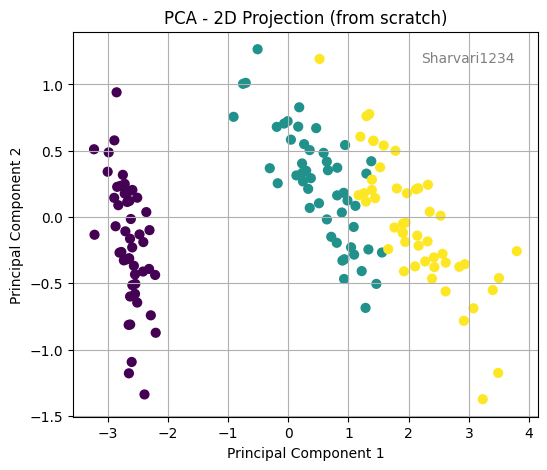

Explained Variance Ratio: [0.92461872 0.05306648 0.01710261 0.00521218]
Cumulative Variance (2 components): 0.9776852063187949


In [24]:
# ==========================================
# Q5 — PCA Implementation from Scratch
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

username = "Sharvari1234"

# Step 1: Load dataset (Iris or any suitable dataset)
data = load_iris()
X = data.data
y = data.target

# Step 2: Standardize (mean normalization)
X_meaned = X - np.mean(X, axis=0)

# Step 3: Compute Covariance Matrix
cov_mat = np.cov(X_meaned, rowvar=False)

# Step 4: Compute Eigenvalues and Eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)

# Step 5: Sort eigenvalues & eigenvectors in decreasing order
sorted_index = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[sorted_index]
eigen_vectors = eigen_vectors[:, sorted_index]

# Step 6: Choose top k principal components (k=2)
k = 2
eigenvector_subset = eigen_vectors[:, :k]

# Step 7: Transform the data
X_reduced = np.dot(X_meaned, eigenvector_subset)

# Step 8: Plot the reduced data
plt.figure(figsize=(6, 5))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', s=40)
plt.title("PCA - 2D Projection (from scratch)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes,
         ha='right', va='top', color='gray')
plt.grid(True)
plt.show()

# Step 9: Display Explained Variance Ratio
explained_variance_ratio = eigen_values / np.sum(eigen_values)
print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Variance (2 components):", np.sum(explained_variance_ratio[:2]))


Reconstruction Mean Squared Error (k=2): 0.025341

Original Data (first 5 rows):
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]

Reconstructed Data (first 5 rows):
 [[5.083 3.517 1.403 0.214]
 [4.746 3.157 1.464 0.24 ]
 [4.704 3.196 1.308 0.175]
 [4.642 3.057 1.461 0.24 ]
 [5.072 3.527 1.364 0.197]]


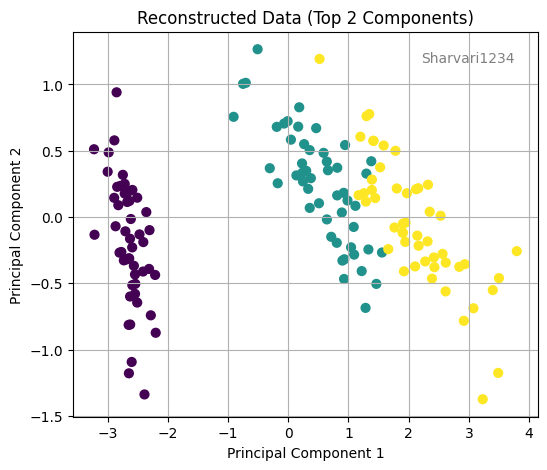

In [25]:
# ==========================================
# Q6 — PCA Reconstruction and Error Analysis
# ==========================================

# Reuse results from Q5: X_meaned, eigen_vectors, eigen_values, etc.
# (Make sure you run Q5 before this cell)

# Step 1: Choose same top-k components used for reduction
k = 2
eigenvector_subset = eigen_vectors[:, :k]

# Step 2: Project data onto top-k components (PCA space)
X_reduced = np.dot(X_meaned, eigenvector_subset)

# Step 3: Reconstruct data from reduced representation
X_reconstructed = np.dot(X_reduced, eigenvector_subset.T) + np.mean(X, axis=0)

# Step 4: Compute reconstruction error (Mean Squared Error)
mse = np.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction Mean Squared Error (k={k}): {mse:.6f}")

# Step 5: Compare first few original vs reconstructed samples
print("\nOriginal Data (first 5 rows):\n", np.round(X[:5], 3))
print("\nReconstructed Data (first 5 rows):\n", np.round(X_reconstructed[:5], 3))

# Step 6: Visualize reconstruction (2D projection)
plt.figure(figsize=(6, 5))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', s=40)
plt.title(f"Reconstructed Data (Top {k} Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.text(0.95, 0.95, username, transform=plt.gca().transAxes,
         ha='right', va='top', color='gray')
plt.grid(True)
plt.show()


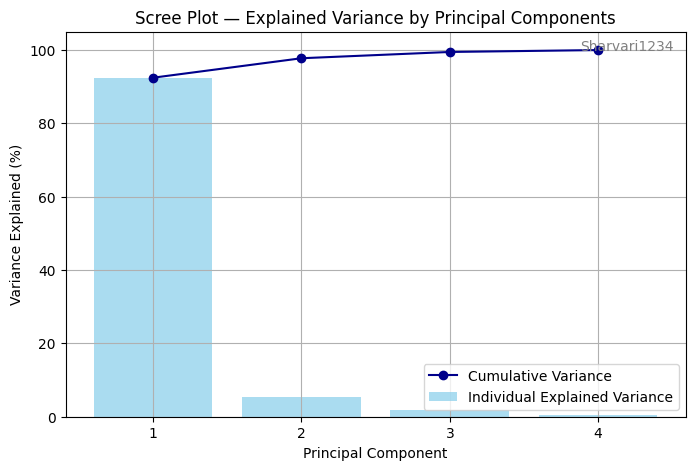

Components 1 to 1: 92.46% variance explained
Components 1 to 2: 97.77% variance explained
Components 1 to 3: 99.48% variance explained
Components 1 to 4: 100.00% variance explained

Optimal number of components to retain (>=95% variance): 2


In [26]:
# ==========================================
# Q7 — PCA Explained Variance & Scree Plot
# ==========================================
import numpy as np
import matplotlib.pyplot as plt

username = "Sharvari1234"

# Ensure PCA results from Q5 are available: eigen_values, eigen_vectors, X_meaned

# Step 1: Compute total variance
total_variance = np.sum(eigen_values)

# Step 2: Compute explained variance ratio for each principal component
explained_variance_ratio = eigen_values / total_variance

# Step 3: Compute cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Step 4: Plot Scree Plot (individual + cumulative variance)
plt.figure(figsize=(8, 5))
components = np.arange(1, len(eigen_values) + 1)

# Plot individual explained variance
plt.bar(components, explained_variance_ratio * 100, alpha=0.7, color='skyblue', label='Individual Explained Variance')

# Plot cumulative variance curve
plt.plot(components, cumulative_variance * 100, marker='o', color='darkblue', label='Cumulative Variance')

plt.title("Scree Plot — Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.xticks(components)
plt.legend()
plt.grid(True)
plt.text(0.98, 0.98, username, transform=plt.gca().transAxes,
         ha='right', va='top', color='gray')
plt.show()

# Step 5: Print cumulative variance summary
for i, var in enumerate(cumulative_variance):
    print(f"Components 1 to {i+1}: {var*100:.2f}% variance explained")

# Step 6: Choose number of components capturing at least 95% variance
k_optimal = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nOptimal number of components to retain (>=95% variance): {k_optimal}")
